In [ ]:
!pip install ultralytics
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.4/910.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from roboflow import Roboflow
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


###Dataset Loading

In [ ]:
rf = Roboflow(api_key="mba7WJ2akxCUlXn5rEPY")
project = rf.workspace("viren-dhanwani").project("tennis-ball-detection")
version = project.version(6)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to tennis-ball-detection-6 in yolov11:: 100%|██████████| 1168/1168 [00:00<00:00, 5317.37it/s]


In [ ]:

train_dir = '/content/tennis-ball-detection-6/train/images'
val_dir = '/content/tennis-ball-detection-6/valid/images'
test_dir = '/content/tennis-ball-detection-6/test/images'

num_train = len(os.listdir(train_dir))
num_val = len(os.listdir(val_dir))
num_test = len(os.listdir(test_dir))

print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_val}")
print(f"Number of test samples: {num_test}")

Number of training samples: 428
Number of validation samples: 100
Number of test samples: 50


#### Visualize as a Subplot

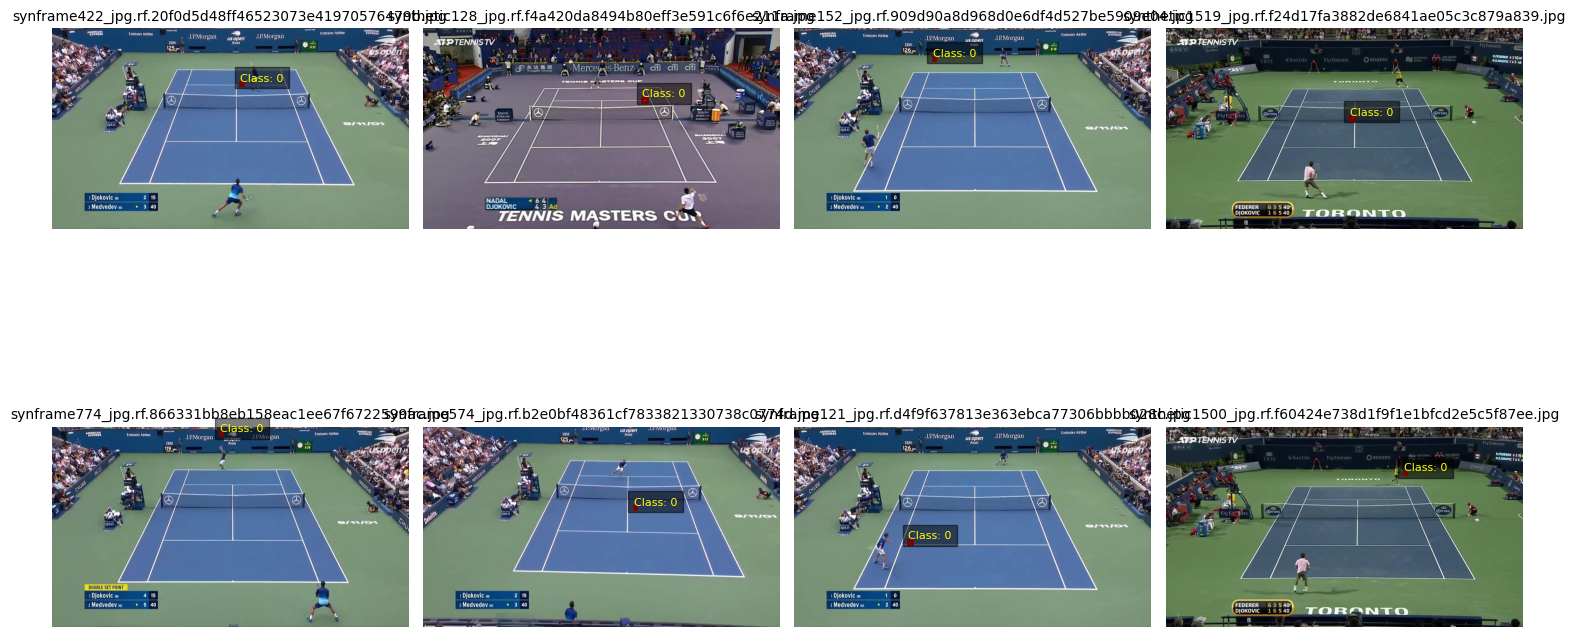

In [ ]:
def vis_image_bb_subplots(img_fld, lbl_fld, rows=2, cols=4):

    img_files = sorted([f for f in os.listdir(img_fld) if f.endswith(('.jpg', '.png', '.jpeg'))])
    random_files = random.sample(img_files, rows * cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for ax, img_file in zip(axes, random_files):
        img_path = os.path.join(img_fld, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        lbl_file = os.path.join(lbl_fld, os.path.splitext(img_file)[0] + '.txt')
        ax.imshow(img)

        if os.path.exists(lbl_file):
            with open(lbl_file, 'r') as f:
                for line in f:
                    class_id, x_center, y_center, width, height = map(float, line.split())

                    img_height, img_width, _ = img.shape
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height

                    x_min = x_center - (width / 2)
                    y_min = y_center - (height / 2)

                    rect = patches.Rectangle((x_min, y_min), width, height,
                                             linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x_min, y_min - 5, f'Class: {int(class_id)}', color='yellow', fontsize=8,
                            bbox=dict(facecolor='black', alpha=0.5))

        ax.set_title(f"{img_file}", fontsize=10)
        ax.axis('off')

    for ax in axes[len(random_files):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

images_folder = '/content/tennis-ball-detection-6/train/images'
labels_folder = '/content/tennis-ball-detection-6/train/labels'
vis_image_bb_subplots(images_folder, labels_folder, rows=2, cols=4)

### Train the YOLOv11 model

In [ ]:
model = YOLO('yolo11x.pt')

result = model.train(data = '/content/tennis-ball-detection-6/data.yaml',
                     epochs = 25,
                     batch = 8,
                     imgsz = 1280)

100%|██████████| 109M/109M [00:00<00:00, 294MB/s] 


Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/tennis-ball-detection-6/data.yaml, epochs=25, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 13.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.4MB/s]


AMP: checks passed ✅


train: Scanning /content/tennis-ball-detection-6/train/labels... 428 images, 2 backgrounds, 0 corrupt: 100%|██████████| 428/428 [00:00<00:00, 1319.20it/s]

train: New cache created: /content/tennis-ball-detection-6/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/tennis-ball-detection-6/valid/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1261.90it/s]

val: New cache created: /content/tennis-ball-detection-6/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      33.7G      3.041      46.37      1.152          8       1280: 100%|██████████| 54/54 [00:26<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        100        101          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      33.7G      3.233      12.03      1.171          6       1280: 100%|██████████| 54/54 [00:24<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]

                   all        100        101          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      33.5G      3.005      7.201      1.143          7       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]

                   all        100        101          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      33.7G      2.896      3.154      1.091         12       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        100        101     0.0083      0.149    0.00274   0.000961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      33.7G      2.689      2.341      1.079          6       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]

                   all        100        101     0.0083      0.149    0.00274   0.000961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      33.7G      2.709      2.233       1.05          9       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]

                   all        100        101      0.335      0.376      0.302     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      33.7G      2.657      2.235      1.013          8       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]

                   all        100        101      0.355     0.0382      0.032     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      33.7G      2.556       1.99      1.005          8       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        100        101      0.582      0.277       0.27      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      33.7G       2.59      1.984      1.031          9       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

                   all        100        101      0.737      0.624      0.656      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      33.7G      2.519      1.902     0.9906          5       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]

                   all        100        101      0.643      0.572      0.589       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      33.7G      2.417      1.816     0.9873          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

                   all        100        101      0.662      0.614      0.657      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      33.7G      2.369       1.76     0.9751          7       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]

                   all        100        101      0.662      0.614      0.681      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      33.7G      2.412      1.696      1.033          6       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]

                   all        100        101      0.718      0.614      0.685      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      33.7G      2.394      1.675     0.9775          5       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        100        101      0.757      0.617      0.718      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      33.7G      2.279      1.556     0.9855          6       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]

                   all        100        101      0.665      0.564      0.589       0.23


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      33.7G      2.254       1.63      1.015          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

                   all        100        101       0.71      0.574      0.686      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      33.7G      2.203      1.574      1.009          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]

                   all        100        101      0.872      0.624      0.758      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      33.7G      2.242      1.609      1.026          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]

                   all        100        101      0.717      0.601      0.666      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      33.7G       2.18       1.55     0.9944          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]

                   all        100        101      0.833      0.624      0.728       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      33.7G      2.055      1.317     0.9929          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]

                   all        100        101      0.749      0.693      0.776      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      33.7G      1.992      1.342     0.9576          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]

                   all        100        101      0.883      0.683      0.786       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      33.7G      2.079      1.265     0.9864          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]

                   all        100        101      0.818      0.564      0.705      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      33.7G      2.116      1.357     0.9706          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]

                   all        100        101       0.82      0.614       0.75      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      33.7G      2.042       1.27     0.9719          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]

                   all        100        101      0.878      0.762      0.827      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      33.7G      2.011      1.228     0.9706          4       1280: 100%|██████████| 54/54 [00:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]

                   all        100        101      0.882      0.741       0.82      0.373



25 epochs completed in 0.197 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 114.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        100        101      0.884      0.762      0.826      0.413
Speed: 0.3ms preprocess, 8.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train


In [ ]:
model = YOLO('/content/ball_detection_model.pt')
result2 = model.track('/content/Tennis.mp4', conf = 0.3, save = True)

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.2s, installed 1 package: ['lap>=0.5.12']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/231) /content/Tennis.mp4: 736x1280 1 tennis ball, 71.9ms
video 1/1 (frame 2/231) /content/Tennis.mp4: 736x1280 1 